In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.preprocessing.image import  img_to_array, load_img
from skimage import io, color
from PIL import Image
from tqdm import tqdm

# Single Opponent Neuron activation

In [2]:
sigma_center = 0.6
sigma_ring = 1.54

k_off = 1 # тормозящая область (знак активации отрицательный)
k_on = 2 # возбуждающая область (знак активации положительный)

In [3]:
X = np.linspace(-3, 3, 7)
Y = np.linspace(-3, 3, 7)

xx, yy = np.meshgrid(X, Y)

G_center_on = np.exp(-(xx**2 + yy**2)/(2*sigma_center**2)) * (-1)**k_on
G_ring_on = np.exp(-(xx**2 + yy**2)/(2*sigma_ring**2)) * (1 / math.sqrt(2 * np.pi)) * (-1)**k_on
G_center_off = np.exp(-(xx**2 + yy**2)/(2*sigma_center**2)) * (-1)**k_off
G_ring_off = np.exp(-(xx**2 + yy**2)/(2*sigma_ring**2)) * (1 / math.sqrt(2 * np.pi)) * (-1)**k_off

In [4]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy, startx:startx+cropx]

def zero_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    center = np.zeros(img.shape)
    center[starty:starty+cropy, startx:startx+cropx] = img[starty:starty+cropy, startx:startx+cropx]
    return img - center

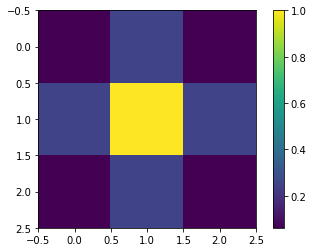

In [5]:
f1 = crop_center(G_center_on, 3, 3)
plt.imshow(f1)
plt.colorbar()
plt.show()
# print('\n'.join(['\t'.join([str(round(cell, 5)) for cell in row]) for row in f1]))

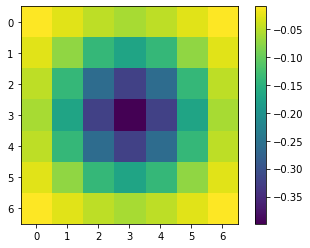

In [6]:
# f2 = zero_center(G_ring_off, 3, 3)
f2 = G_ring_off

plt.imshow(f2)
plt.colorbar()
plt.show()
# print('\n'.join(['\t'.join([str(round(cell, 4)) for cell in row]) for row in f2]))

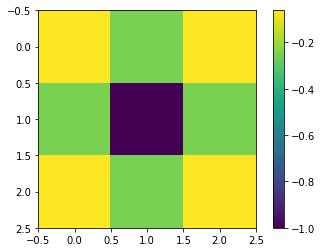

In [7]:
f3 = crop_center(G_center_off, 3, 3)
plt.imshow(f3)
plt.colorbar()
plt.show()
# print('\n'.join(['\t'.join([str(round(cell, 4)) for cell in row]) for row in f3]))

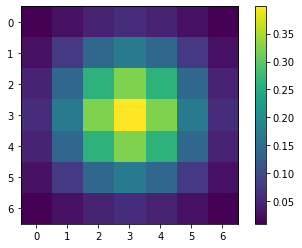

In [8]:
# f4 = zero_center(G_ring_on, 3, 3)
f4 = G_ring_on

plt.imshow(f4)
plt.colorbar()
plt.show()
# print('\n'.join(['\t'.join([str(round(cell, 4)) for cell in row]) for row in f4]))

## Extracting channels from CIE L* a* b*

In [9]:
def extract_cannel(image,idim):
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 ## I need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = color.lab2rgb(z)
    return(z)
    
def plot_lab_spectrums(img):
    lab = color.rgb2lab(img/255.0)
    lab_l = extract_cannel(lab,0)
    lab_a = extract_cannel(lab,1)
    lab_db = extract_cannel(lab,2)

    # Plot the results
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    data = [('L: lightness', lab_l), ('a: green-magenta channel', lab_a), ('b: blue-yellow channel', lab_db)]

    for ax, (title, img) in zip(axes, data):
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()
    plt.show()

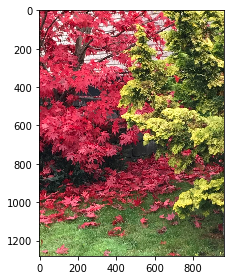

In [10]:
io.imshow("trees.jpg")
trees = img_to_array(load_img("trees.jpg"))

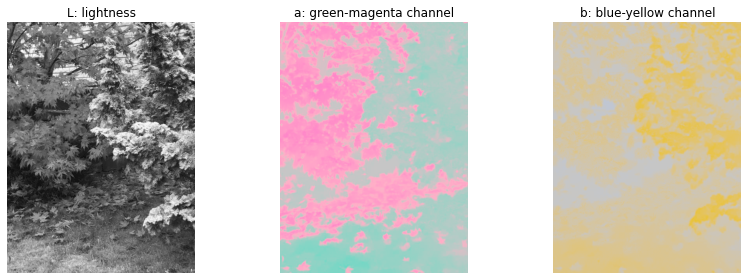

In [11]:
img = trees
plot_lab_spectrums(trees)

In [12]:
image_in_lab1 = color.rgb2lab(img/255.0)

a_channel = np.zeros(img.shape)
a_channel[:,:,0]=60
a_channel = image_in_lab1[:,:,1]

b_channel = np.zeros(img.shape)
b_channel[:,:,0]=60
b_channel = image_in_lab1[:,:,2]

## Convolution

In [13]:
def convolve(image, kernel, strides):
    # Cross Correlation
    # kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Iterate through image
    for y in tqdm(range(image.shape[1])):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * image[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

Kernel Markdown

In [14]:
def convolve_with_markdown(image, kernel_markdown, kernel_list, strides):
    # Cross Correlation
    # kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    x_kernel_shape = kernel_list[0].shape[0]
    y_kernel_shape = kernel_list[0].shape[1]

    x_markdown_shape = kernel_markdown.shape[0]
    y_markdown_shape = kernel_markdown.shape[1]

    x_img_shape = image.shape[0]
    y_img_shape = image.shape[1]

    # Shape of Output Convolution
    x_output = int(((x_img_shape - x_kernel_shape + 2) / strides) + 1)
    y_output = int(((y_img_shape - y_kernel_shape + 2) / strides) + 1)
    output = np.zeros((x_output, y_output))

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - y_kernel_shape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - x_kernel_shape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel_list[kernel_markdown[x,y]]
                            * image[x: x + x_kernel_shape, y: y + y_kernel_shape]).sum()
                except:
                    break

    return output

In [15]:
mkdwn = np.random.randint(2, size=(img.shape[0] - 2, img.shape[1] - 2))
# mkdwn = np.zeros((img.shape[0] - 2, img.shape[1] - 2))
# mkdwn[400:, 400:] = 1
kern_list = [G_center_on - G_ring_off, G_center_off - G_ring_on]
mkdwn

## Samples

 99%|█████████▉| 954/960 [00:06<00:00, 137.68it/s]
/opt/python/envs/default/lib/python3.8/site-packages/skimage/_shared/utils.py:338: UserWarning: Color data out of range: Z < 0 in 580402 pixels
  return func(*args, **kwargs)


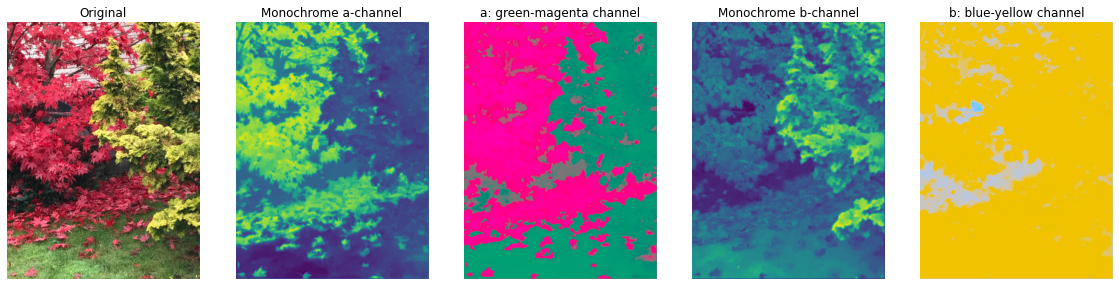

In [16]:
activation_map_a_channel = convolve(a_channel, G_center_on - G_ring_off, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

activation_map_b_channel = convolve(b_channel, G_center_on - G_ring_off, 1)
res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
res[:,:,0]=80
res[:,:,2]=activation_map_b_channel
b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=5, figsize=(16, 4))
data = [('Original', trees/255.0), ('Monochrome a-channel', activation_map_a_channel), ('a: green-magenta channel', a_map), ('Monochrome b-channel', activation_map_b_channel), ('b: blue-yellow channel', b_map)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

 99%|█████████▉| 954/960 [00:06<00:00, 137.59it/s]


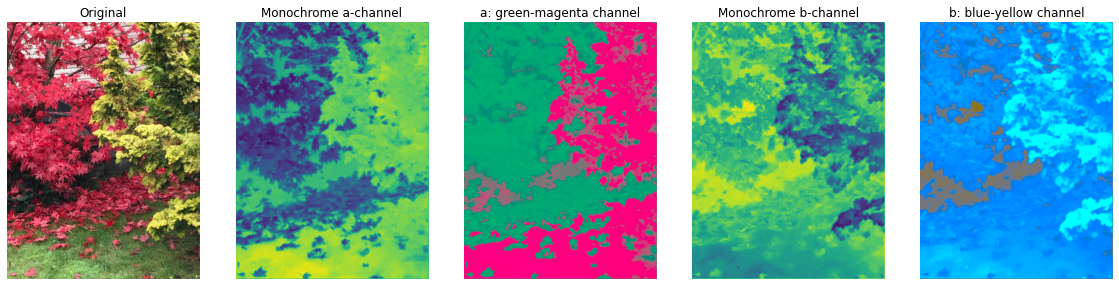

In [17]:
activation_map_a_channel = convolve(a_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

activation_map_b_channel = convolve(b_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,2]=activation_map_b_channel
b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=5, figsize=(16, 4))
data = [('Original', trees/255.0), ('Monochrome a-channel', activation_map_a_channel), ('a: green-magenta channel', a_map), ('Monochrome b-channel', activation_map_b_channel), ('b: blue-yellow channel', b_map)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

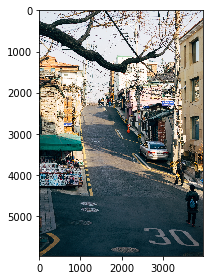

In [18]:
#sample convolution
io.imshow("test_set/markus-winkler-eH2Uwa3nYg8-unsplash.jpg")
horses = img_to_array(load_img("test_set/markus-winkler-eH2Uwa3nYg8-unsplash.jpg"))

In [19]:
image_in_lab2 = color.rgb2lab(horses/255.0)

horses_a_channel = np.zeros(horses.shape)
horses_a_channel[:,:,0]=60
horses_a_channel = image_in_lab2[:,:,1]

horses_b_channel = np.zeros(horses.shape)
horses_b_channel[:,:,0]=60
horses_b_channel = image_in_lab2[:,:,2]

In [0]:
activation_map_a_channel = convolve(horses_a_channel, G_center_on - G_ring_off, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

# activation_map_b_channel = convolve(horses_b_channel, G_center_on - G_ring_off, 1)
# res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
# res[:,:,0]=50
# res[:,:,2]=activation_map_b_channel
# b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
data = [('Original', horses/255.0), ('А-channel: G_center_on - G_ring_off ', activation_map_a_channel), ('B-channel: G_center_on - G_ring_off', activation_map_b_channel)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

# im_b = Image.fromarray(activation_map_a_channel)
# im_b.show()

100%|█████████▉| 3973/3979 [02:52<00:00, 23.04it/s]


KeyboardInterrupt: KeyboardInterrupt: interrupted by user

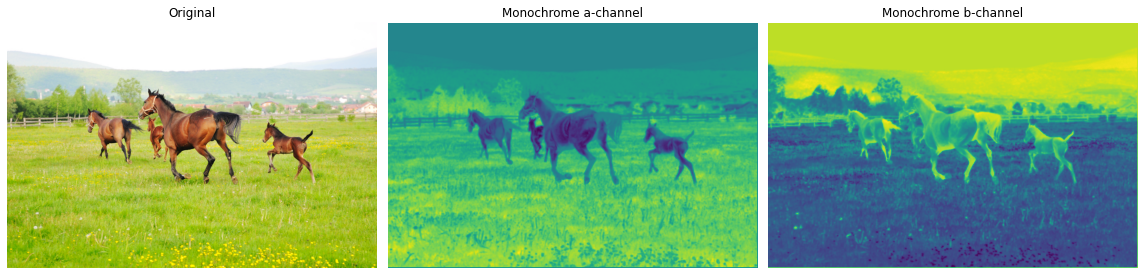

In [28]:
activation_map_a_channel = convolve(horses_a_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

activation_map_b_channel = convolve(horses_b_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,2]=activation_map_b_channel
b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
data = [('Original', horses/255.0), ('Monochrome a-channel', activation_map_a_channel), ('Monochrome b-channel', activation_map_b_channel)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

In [21]:
fishes = img_to_array(load_img("fishes.jpg"))

In [22]:
image_in_lab2 = color.rgb2lab(fishes/255.0)

fishes_a_channel = np.zeros(fishes.shape)
fishes_a_channel[:,:,0]=60
fishes_a_channel = image_in_lab2[:,:,1]

fishes_b_channel = np.zeros(fishes.shape)
fishes_b_channel[:,:,0]=60
fishes_b_channel = image_in_lab2[:,:,2]

/opt/python/envs/default/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 634130 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


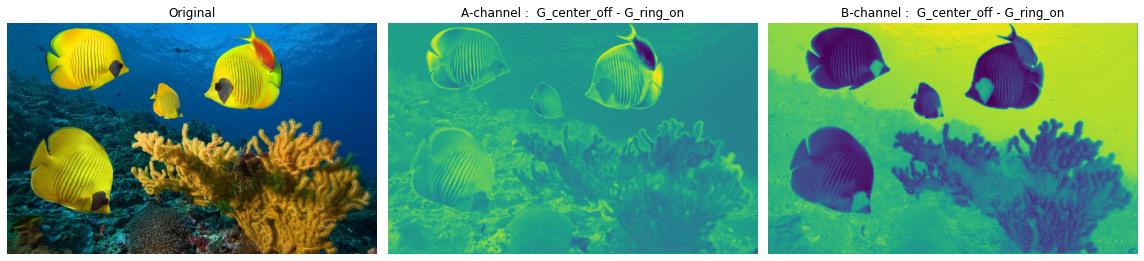

In [32]:
activation_map_a_channel = convolve(fishes_a_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

activation_map_b_channel = convolve(fishes_b_channel, G_center_off - G_ring_on, 1)
res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,2]=activation_map_b_channel
b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
data = [('Original', fishes/255.0), ('A-channel :  G_center_off - G_ring_on', activation_map_a_channel), ('B-channel :  G_center_off - G_ring_on', activation_map_b_channel)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

/opt/python/envs/default/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 661991 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


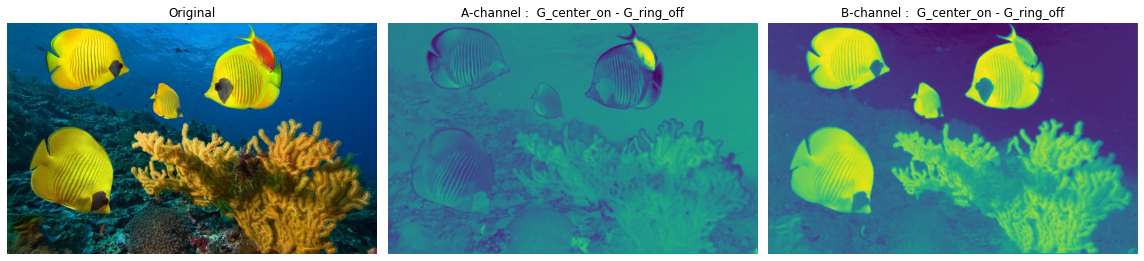

In [31]:
activation_map_a_channel = convolve(fishes_a_channel, G_center_on - G_ring_off, 1)
res = np.zeros((activation_map_a_channel.shape[0],activation_map_a_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,1]=activation_map_a_channel
a_map = color.lab2rgb(res)

activation_map_b_channel = convolve(fishes_b_channel, G_center_on - G_ring_off, 1)
res = np.zeros((activation_map_b_channel.shape[0],activation_map_b_channel.shape[1], 3))
res[:,:,0]=50
res[:,:,2]=activation_map_b_channel
b_map = color.lab2rgb(res)

# Plot the results
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
data = [('Original', fishes/255.0), ('A-channel :  G_center_on - G_ring_off', activation_map_a_channel), ('B-channel :  G_center_on - G_ring_off', activation_map_b_channel)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

# Double Opponent Neuron activation

In [37]:
sigma_d = 0.8

G_d = 8 * np.exp(-(xx**2 + yy**2)/(2*sigma_d**2)) * (1 - (xx**2 + yy**2)/(2*sigma_d**2))

x = np.matrix(G_d*(127))
print(x)
print('sum = ', x.sum())

[[-1.03670182e-02 -3.61250135e-01 -2.80075154e+00 -5.41586665e+00
  -2.80075154e+00 -3.61250135e-01 -1.03670182e-02]
 [-3.61250135e-01 -1.02970424e+01 -5.93969108e+01 -9.48598397e+01
  -5.93969108e+01 -1.02970424e+01 -3.61250135e-01]
 [-2.80075154e+00 -5.93969108e+01 -1.19792908e+02  1.01753465e+02
  -1.19792908e+02 -5.93969108e+01 -2.80075154e+00]
 [-5.41586665e+00 -9.48598397e+01  1.01753465e+02  1.01600000e+03
   1.01753465e+02 -9.48598397e+01 -5.41586665e+00]
 [-2.80075154e+00 -5.93969108e+01 -1.19792908e+02  1.01753465e+02
  -1.19792908e+02 -5.93969108e+01 -2.80075154e+00]
 [-3.61250135e-01 -1.02970424e+01 -5.93969108e+01 -9.48598397e+01
  -5.93969108e+01 -1.02970424e+01 -3.61250135e-01]
 [-1.03670182e-02 -3.61250135e-01 -2.80075154e+00 -5.41586665e+00
  -2.80075154e+00 -3.61250135e-01 -1.03670182e-02]]
sum =  1.0384647870855948


0.5192323935427974


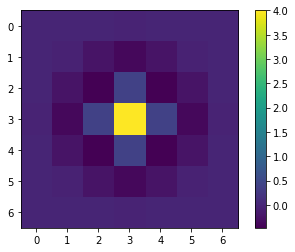

In [34]:
f5 = G_d

plt.imshow(f5)
plt.colorbar()
plt.show()

x = np.matrix(G_d*127)
print(x.sum())

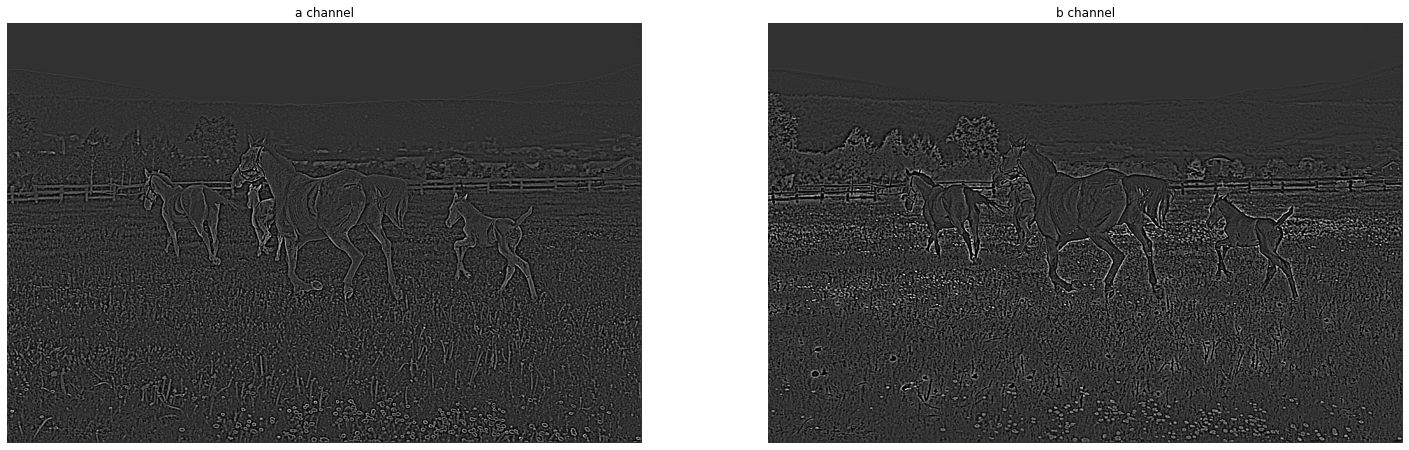

In [39]:
activation_a_double = convolve(horses_a_channel, G_d, 1)
activation_b_double = convolve(horses_b_channel, G_d, 1)

im_a = Image.fromarray(activation_a_double + 50)
im_b = Image.fromarray(activation_b_double + 50)

fig = plt.figure(figsize=(25, 15))

fig.add_subplot(1, 2, 1)
plt.imshow(im_a)
plt.axis('off')
plt.title("a channel")

fig.add_subplot(1, 2, 2)
plt.imshow(im_b)
plt.axis('off')
plt.title("b channel")

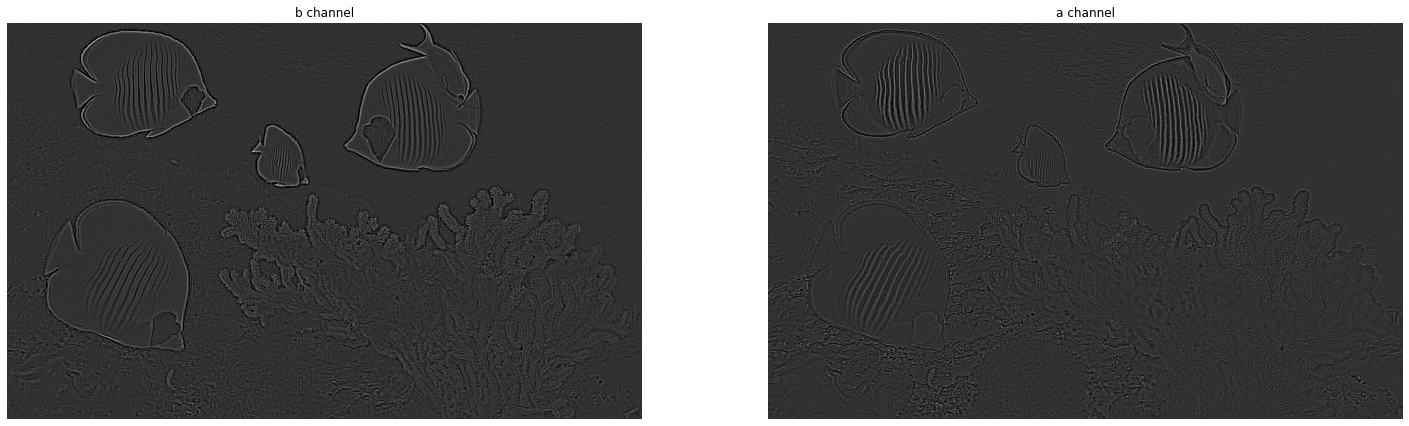

In [38]:
activation_a_double = convolve(fishes_a_channel, G_d, 1)
activation_b_double = convolve(fishes_b_channel, G_d, 1)


im_a = Image.fromarray(activation_a_double + 50)
im_b = Image.fromarray(activation_b_double + 50)

fig = plt.figure(figsize=(25, 15))

fig.add_subplot(1, 2, 1)
plt.imshow(im_b)
plt.axis('off')
plt.title("b channel")

fig.add_subplot(1, 2, 2)
plt.imshow(im_a)
plt.axis('off')
plt.title("a channel")